## Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [9]:
x1 = torch.arange(0.01, 4.01, 0.01)
x1.shape

torch.Size([400])

In [10]:
x1 = torch.cat([x1, -x1])
x1.shape

torch.Size([800])

In [12]:
x2_plus = torch.pow(x1, -1)
x2_plus.shape

torch.Size([800])

In [14]:
x2_minus = -x2_plus
x2_minus.shape

torch.Size([800])

In [19]:
X_plus = torch.cat([x1.unsqueeze(1), x2_plus.unsqueeze(1)], 1)
X_plus.shape

torch.Size([800, 2])

In [20]:
X_minus = torch.cat([x1.unsqueeze(1), x2_minus.unsqueeze(1)], 1)
X_minus.shape

torch.Size([800, 2])

In [21]:
Y_plus = torch.ones((800, 1))
Y_plus.shape

torch.Size([800, 1])

In [22]:
Y_minus = -Y_plus
Y_minus.shape

torch.Size([800, 1])

In [23]:
X = torch.cat([X_plus, X_minus])
Y = torch.cat([Y_plus, Y_minus])

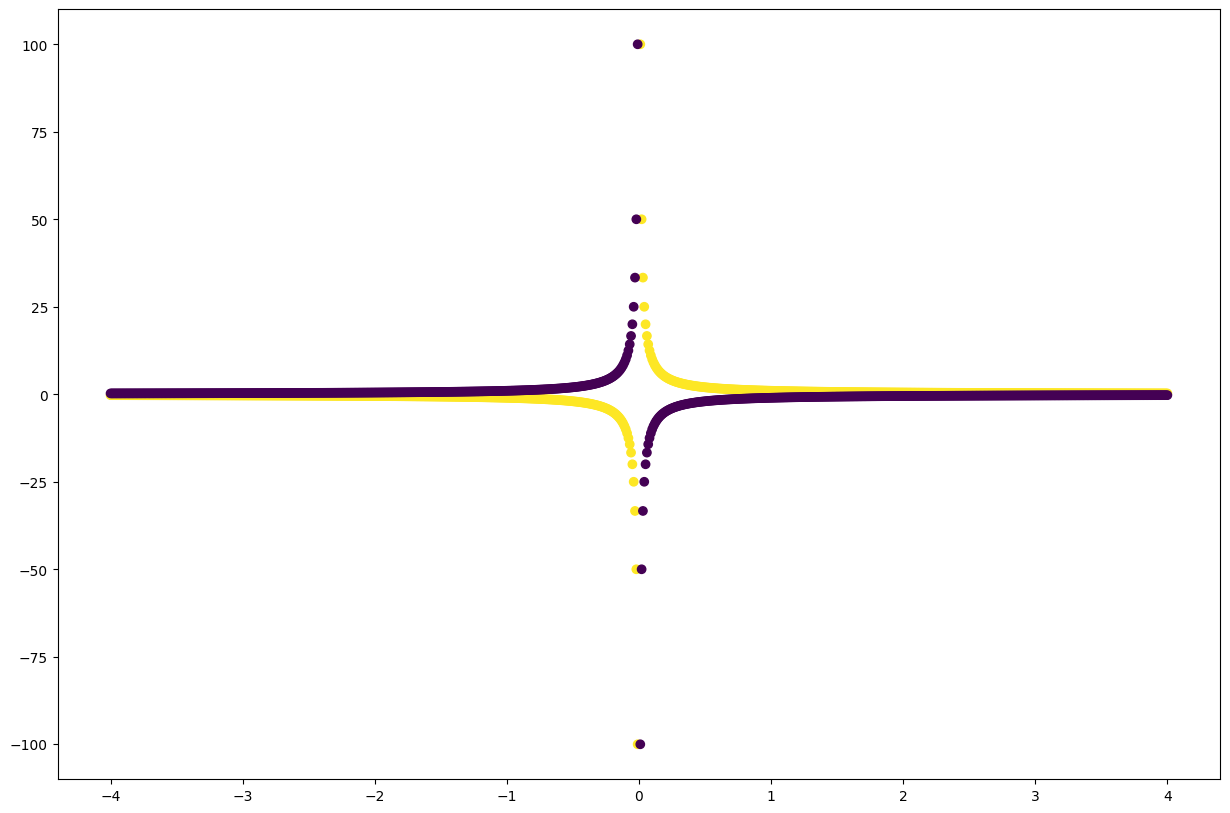

In [30]:
plt.figure(figsize=(15, 10))
plt.scatter(X[:, 0], X[:, 1], c=Y)

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.1)
X_training.shape, X_test.shape, Y_training.shape, Y_test.shape

(torch.Size([1440, 2]),
 torch.Size([160, 2]),
 torch.Size([1440, 1]),
 torch.Size([160, 1]))

In [33]:
X_train, X_val, Y_train, Y_val = train_test_split(X_training, Y_training, test_size=1/9)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

(torch.Size([1280, 2]),
 torch.Size([160, 2]),
 torch.Size([1280, 1]),
 torch.Size([160, 1]))

## SVM

In [39]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [64]:
# def dim_prod_kernel(u, v):
#     return u[0]*u[1]*v[0]*v[1]

def dim_prod_kernel(U, V):
    K = torch.zeros((U.shape[0], V.shape[0]))
    for i, u in enumerate(U):
        for j, v in enumerate(V):
            K[i][j] = u[0]*u[1]*v[1]*v[0]
    return K

In [65]:
model = SVC(max_iter=1000, kernel=dim_prod_kernel)

In [66]:
model.fit(X_train, Y_train.squeeze())

SVC(kernel=<function dim_prod_kernel at 0x7f0b1f71f5b0>, max_iter=1000)

In [67]:
preds_train, preds_val = model.predict(X_train), model.predict(X_val)
score_train, score_val = accuracy_score(Y_train.squeeze(), preds_train), accuracy_score(Y_val.squeeze(), preds_val)
score_train, score_val

(1.0, 1.0)